# Machine Learning for Stock Trading:  Unsupervised Learning Techniques

**Hugh Donnelly, CFA**<br>
*AlphaWave Data*

**April 2021**

## Introduction

This example employs several unsupervised learning techniques in `scikit-learn` to extract the stock market structure from variations in historical close prices. The quantity that we use is the daily variation in close prices because prices that are linked tend to cofluctuate during a day.

Jupyter Notebooks are available on Google Colab and Github.

For this project, we use several Python-based scientific computing technologies listed below.

In [1]:
import requests
import numpy as np
import pandas as pd

import pymc3 as pm
import theano as th
import seaborn as sns

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.preprocessing import MinMaxScaler
from sklearn import cluster, covariance, manifold

%matplotlib notebook

import warnings
warnings.filterwarnings('ignore')

## 1. Define the Stock Universe

We start by specifying that we will constrain our search for pairs to a large and liquid single stock universe. To achieve this, we create a function that scrapes the tickers of the S&P 500 and then cleans the tickers by replacing those containing a `.` with a `-` so we can easily use them in [AlphaWave Data's APIs](https://www.alphawavedata.com/).

In [2]:
# Scrape the S&P 500 tickers from Wikipedia

def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']
    return ticker_options

In [3]:
# Run the ticker scrape function
# Let's convert the get_tickers() output to a list and 
# replace tickers that have '.' with '-' so we can use AlphaWave Data APIs

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")


After scraping all the tickers in the S&P 500, let's reduce the ticker list with the below code in order to present a simplified stock market visualization.  This step is not required and is implemented only to provide an example.

In [4]:
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

In [5]:
stock_dict_list = []
for key in symbol_dict.keys():
    stock_dict_list.append(key)
    
stock_tickers = list(set(stock_tickers) & set(stock_dict_list))
stock_tickers

['HD',
 'MMM',
 'AIG',
 'DD',
 'CSCO',
 'WBA',
 'XOM',
 'HPQ',
 'KMB',
 'PFE',
 'F',
 'CL',
 'IBM',
 'BA',
 'AAPL',
 'MSFT',
 'CVS',
 'WMT',
 'K',
 'AMZN',
 'BAC',
 'TXN',
 'PG',
 'MCD',
 'CMCSA',
 'AXP',
 'GS',
 'CAT',
 'PEP',
 'GD',
 'VLO',
 'LMT',
 'WFC',
 'MDLZ',
 'MAR',
 'JPM',
 'KO',
 'GE',
 'CVX',
 'NOC',
 'COP']

## 2. Retrieve Stock Price Data

We can use the [5 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_77d902f9-627d-4088-98b8-8fe12e31f9c8) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints) to pull in the five year historical prices.  From this, we are going to calculate the daily returns for each stock selected. With these returns, we can produce a 2D graph of the stock market.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [6]:
#fetch 5 years of daily return data

url = "https://stock-prices2.p.rapidapi.com/api/v1/resources/stock-prices/5y"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

stock_frames = []

for ticker in stock_tickers:
    querystring = {"ticker":ticker}
    stock_daily_price_response = requests.request("GET", url, headers=headers, params=querystring)

    # Create Stock Prices DataFrame
    stock_daily_price_df = pd.DataFrame.from_dict(stock_daily_price_response.json())
    stock_daily_price_df = stock_daily_price_df.transpose()
    stock_daily_price_df = stock_daily_price_df.rename(columns={'Close':ticker})
    stock_daily_price_df = stock_daily_price_df[{ticker}]
    stock_frames.append(stock_daily_price_df)

combined_stock_price_df = pd.concat(stock_frames, axis=1, sort=True)
combined_stock_price_df = combined_stock_price_df.dropna(how='all')
combined_stock_price_df = combined_stock_price_df.fillna("")

pct_change_combined_stock_df = combined_stock_price_df.pct_change()
pct_change_combined_stock_df = pct_change_combined_stock_df.dropna()
pct_change_combined_stock_df


,HD,MMM,AIG,DD,CSCO,WBA,XOM,HPQ,KMB,PFE,...,LMT,WFC,MDLZ,MAR,JPM,KO,GE,CVX,NOC,COP
2016-04-29,0.008740,0.002275,-0.000179,-0.015163,-0.016810,-0.013317,0.004203,-0.023866,-0.008317,-0.006077,...,-0.001461,-0.008530,-0.009682,0.012276,-0.006289,0.003809,-0.004854,-0.002148,0.003161,0.002517
2016-05-02,0.016133,0.005736,0.013794,0.000760,-0.004365,0.016145,0.008258,-0.012225,0.000240,0.002752,...,0.003701,0.012205,0.031424,-0.000713,0.009335,0.004018,0.004553,0.011059,0.009939,-0.019670
2016-05-03,-0.011099,-0.002198,-0.011486,-0.016714,-0.018634,0.011172,-0.011444,-0.033828,0.007267,0.027439,...,0.006259,-0.011662,-0.014443,0.000856,-0.019282,-0.003112,-0.008417,-0.019262,0.006193,-0.037780
2016-05-04,0.004608,-0.004822,-0.019485,-0.007340,-0.015636,0.000368,-0.001930,-0.010248,0.014271,-0.008902,...,0.005582,-0.013704,0.000000,-0.012411,-0.015825,0.003122,-0.018283,-0.007205,0.004532,-0.037045
2016-05-05,-0.003625,0.003649,-0.000729,-0.010508,-0.008699,-0.000368,0.001137,-0.012079,-0.004456,0.005090,...,0.009025,0.000409,0.005725,0.000578,-0.005360,0.001779,-0.005986,0.008251,0.006554,-0.004607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-22,-0.013775,0.000100,-0.006416,-0.025035,-0.008280,-0.027197,-0.013036,-0.003835,-0.008058,-0.022515,...,-0.018464,-0.012488,-0.000336,0.012987,-0.021058,-0.003113,0.004494,-0.017327,-0.006049,-0.011591
2021-04-23,0.007559,0.006471,0.018941,0.016678,0.007961,0.008368,0.005428,0.019248,-0.058576,0.000518,...,-0.007367,0.027166,-0.000672,0.011729,0.019136,0.000551,0.010440,0.005944,-0.004047,0.005257
2021-04-26,-0.012041,-0.012710,0.004013,0.001562,-0.005201,-0.005470,0.001979,-0.002615,-0.012035,0.000517,...,-0.014074,0.006384,-0.012435,0.000809,0.002464,-0.014871,0.001476,-0.000295,-0.012396,0.010660
2021-04-27,0.001875,-0.025948,0.019146,0.001950,-0.005229,-0.004172,0.013111,0.002913,-0.008198,-0.005946,...,0.003333,0.021522,-0.000851,0.008486,0.004583,-0.001491,-0.005895,0.011623,0.006128,0.020896


In [7]:
variation = pct_change_combined_stock_df
variation.shape

(1258, 41)

## 3. Unsupervised Learning Techniques

### 3.a Learning a graph structure
We use sparse inverse covariance estimation to find which close prices are correlated conditionally on the others. Specifically, sparse inverse covariance gives us a graph, that is a list of connections. For each symbol, the symbols that it is connected to are those useful to explain its fluctuations.

In [8]:
edge_model = covariance.GraphLassoCV(verbose=True)
X = variation.copy()
X /= X.std(axis=0)

In [9]:
edge_model.fit(X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  1 out of 4:   0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  2 out of 4:   0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[GraphicalLassoCV] Done refinement  3 out of 4:   0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


[GraphicalLassoCV] Done refinement  4 out of 4:   1s


GraphLassoCV(alphas=4, assume_centered=False, cv='warn', enet_tol=0.0001,
             max_iter=100, mode='cd', n_jobs=None, n_refinements=4, tol=0.0001,
             verbose=True)

### 3.b Clustering
We use clustering to group together close prices that behave similarly. Here, amongst the [various clustering techniques](https://scikit-learn.org/stable/modules/clustering.html#clustering) available in the `scikit-learn`, we use [Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) as it does not enforce equal-size clusters, and it can choose automatically the number of clusters from the data.

Note that this gives us a different indication than the graph because the graph reflects conditional relations between variables while the clustering reflects marginal properties. Variables clustered together can be considered as having a similar impact at the level of the full stock market.

Let's take a look to see which stocks are in the same clusters.

In [10]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()
names=[]

for stock in pct_change_combined_stock_df.columns.tolist():
    names.append(stock)

names = np.array(names)

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: WBA, CVS
Cluster 2: HD, CSCO, AAPL, MSFT, AMZN, TXN
Cluster 3: KMB, PFE, CL, WMT, K, PG, PEP, MDLZ, KO
Cluster 4: GD, LMT, NOC
Cluster 5: MMM, AIG, DD, HPQ, F, IBM, BA, BAC, CMCSA, AXP, GS, CAT, WFC, MAR, JPM, GE
Cluster 6: XOM, MCD, VLO, CVX, COP


### 3.c Embedding in 2D space
For visualization purposes, we need to lay out the different symbols on a 2D canvas. For this we use Manifold learning techniques to retrieve 2D embedding.

In [11]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

## 4. Visualization
The output of the 3 models (sparse inverse covariance estimation represented by Lasso Cross-Validation, clustering using Affinity Propagation, 2D embedding with Manifold learning) are combined in a 2D graph where nodes represent the stocks and edges represent the connections between stocks:

* the sparse covariance model is used to display the strength of the edges
* cluster labels are used to define the color of the nodes
* the 2D embedding is used to position the nodes in the graph

This example has a fair amount of visualization-related code, as visualization is crucial here to display the graph. One of the challenges is to position the labels minimizing overlap. For this we use a heuristic based on the direction of the nearest neighbor along each axis.

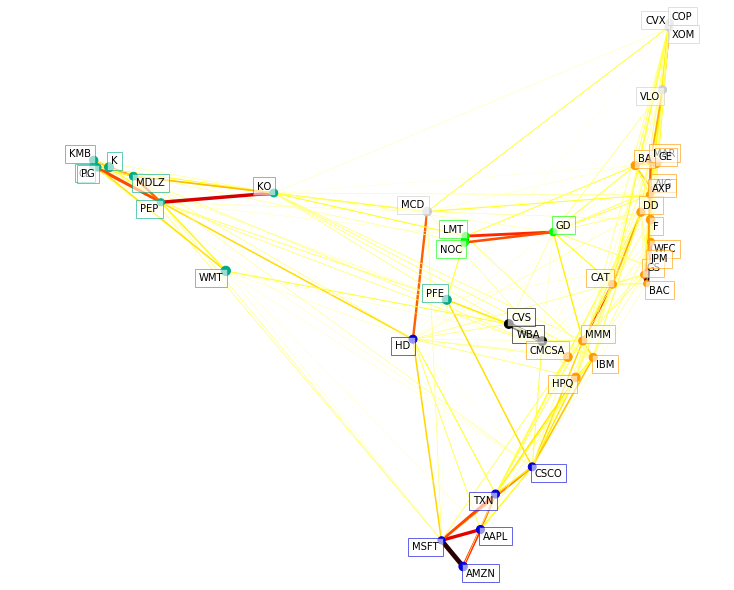

In [12]:
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

As can be seen in the 2D graph, `MSFT` (Microsoft), `AAPL` (Apple), `AMZN` (Amazon), and `TXN` (Texas Instruments) all have the same color nodes, bold lines connecting them, and are positioned closely together on the graph.  This shows that all 3 models identify these stocks as having a close relationship based on variations in historical close prices.  Intuitively, this makes sense as this grouping of stocks have similar economic exposures and regulatory burdens.

## 5. Pairs Trading Analysis

### 5.a Historical Stock Prices

To examine how well our identified pairs trade algorithmically, we first reload the historical stock prices.

In [14]:
stock_data = combined_stock_price_df
stock_data

,HD,MMM,AIG,DD,CSCO,WBA,XOM,HPQ,KMB,PFE,...,LMT,WFC,MDLZ,MAR,JPM,KO,GE,CVX,NOC,COP
2016-04-28,118.058197,144.236649,48.686638,67.304962,23.844116,69.794983,68.963531,10.822201,107.655441,25.869516,...,204.383728,42.844090,39.115650,65.501366,55.309181,37.864113,27.053133,82.445206,189.915390,41.934181
2016-04-29,119.089973,144.564835,48.677921,66.284431,23.443306,68.865532,69.253410,10.563915,106.760033,25.712297,...,204.085144,42.478622,38.736931,66.305466,54.961338,38.008331,26.921810,82.268082,190.515778,42.039734
2016-05-02,121.011208,145.394012,49.349400,66.334831,23.340973,69.977394,69.825287,10.434770,106.785622,25.783049,...,204.840424,42.997078,39.954216,66.258179,55.474419,38.161049,27.044378,83.177864,192.409302,41.212830
2016-05-03,119.668129,145.074448,48.782555,65.226097,22.906048,70.759163,69.026215,10.081781,107.561646,26.490507,...,206.122620,42.495625,39.377140,66.314926,54.404766,38.042278,26.816744,81.575653,193.600845,39.655807
2016-05-04,120.219597,144.374878,47.832016,64.747337,22.547878,70.785225,68.893028,9.978466,109.096657,26.254686,...,207.273132,41.913258,39.377140,65.491920,53.543812,38.161049,26.326458,80.987915,194.478302,38.186752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-22,321.459991,200.899994,46.459999,75.550003,51.500000,52.580002,55.270000,33.770000,140.330002,38.639999,...,380.089996,42.700001,59.549999,146.639999,147.369995,54.439999,13.410000,100.949997,343.429993,49.459999
2021-04-23,323.890015,202.199997,47.340000,76.809998,51.910000,53.020000,55.570000,34.419998,132.110001,38.660000,...,377.290009,43.860001,59.509998,148.360001,150.190002,54.470001,13.550000,101.550003,342.040009,49.720001
2021-04-26,319.989990,199.630005,47.529999,76.930000,51.639999,52.730000,55.680000,34.330002,130.520004,38.680000,...,371.980011,44.139999,58.770000,148.479996,150.559998,53.660000,13.570000,101.519997,337.799988,50.250000
2021-04-27,320.589996,194.449997,48.439999,77.080002,51.369999,52.509998,56.410000,34.430000,129.449997,38.450001,...,373.220001,45.090000,58.720001,149.740005,151.250000,53.580002,13.490000,102.699997,339.869995,51.299999


Since `MSFT` (Microsoft) and `AAPL` (Apple) were identified in the 2D graph as being a good pairs trading candidate, we define them as `symbol_one` and `symbol_two` in our trading algorithm below:

In [15]:
symbol_one = 'MSFT'
symbol_two = 'AAPL'

In [16]:
stock_data = stock_data[[symbol_one,symbol_two]]
stock_data.index.name = 'Date'
stock_data

,MSFT,AAPL
Date,,
2016-04-28,45.756889,22.050558
2016-04-29,45.729378,21.797100
2016-05-02,46.407951,21.773848
2016-05-03,45.646847,22.131937
2016-05-04,45.729378,21.901741
...,...,...
2021-04-22,257.170013,131.940002
2021-04-23,261.149994,134.320007
2021-04-26,261.549988,134.720001


We focus on price data since January 1, 2020 in order to capture the coronavirus sell-off in March 2020 and subsequent stock market recovery.

In [17]:
stock1_name, stock2_name = symbol_one,symbol_two
orig_data = stock_data.loc['2020-01-01':,]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

Let's now plot the historical stock prices for `MSFT` and `AAPL`.

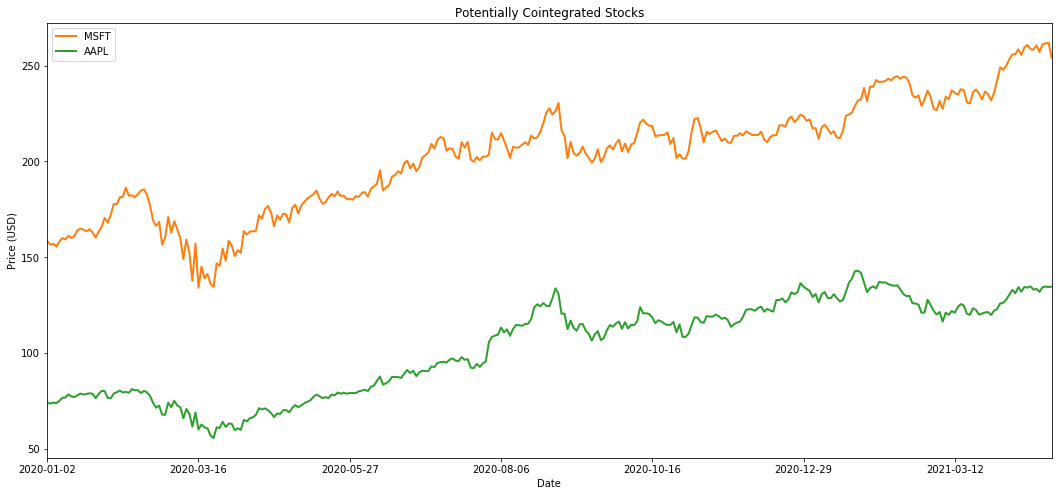

In [18]:
plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

These companies do indeed seem to have related price series.

### 5.b Bayesian Modeling

We take a Bayesian approach to pairs trading using probabilistic programming, which is a form of Bayesian machine learning. Unlike simpler frequentist cointegration tests, our Bayesian approach allows us to monitor the relationship between a pair of equities over time, which allows us to follow pairs whose cointegration parameters change steadily or abruptly. When combined with a simple mean-reversion trading algorithm, we demonstrate this to be a viable theoretical trading strategy, ready for further evaluation and risk management.

To learn more about this Bayesian approach to pairs trading, you can read AlphaWave Data's article titled [Bayesian Pairs Trading using Corporate Supply Chain Data](https://medium.com/@hdonnelly6/bayesian-pairs-trading-using-corporate-supply-chain-data-8b96305686d).

We will use a Bayesian probabilistic programming package called [PyMC3](https://docs.pymc.io/). Its simple syntax is excellent for prototyping as seen with the model description in the code below.

In [19]:
with pm.Model() as model:
    
    # inject external stock data
    stock1 = th.shared(data1)
    stock2 = th.shared(data2)
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sd=beta_sigma,
                                 shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sd=.25)
    likelihood = pm.Normal('y',
                           mu=stock2_regression,
                           sd=sd,
                           observed=stock2)

In [20]:
with model:
    stock1.set_value(data1)
    stock2.set_value(data2)
    trace = pm.sample(2000,tune=1000,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, beta_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
The number of effective samples is smaller than 25% for some parameters.


Let's plot the $\beta$ distribution from the model over time.

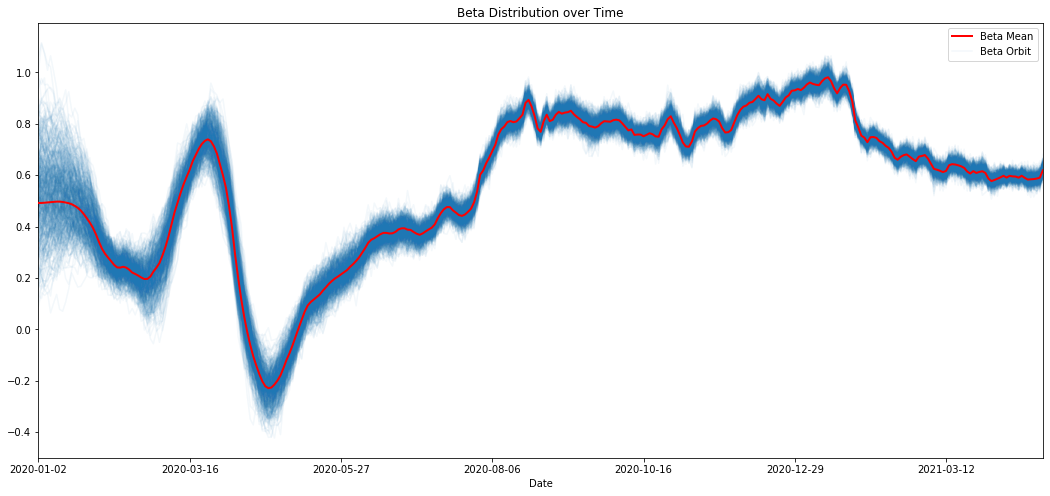

In [21]:
rolling_beta = trace[beta].T.mean(axis=1)

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)
for orbit in trace[beta][:500]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
plt.legend(['Beta Mean','Beta Orbit'])
#plt.savefig("beta distrib.png")

plt.show()

Notice that $\beta$ appears to shift between somewhat fixed regimes, and often does so abruptly.

### 5.c Trading Strategy

Knowing that two stocks may or may not be cointegrated does not explicitly define a trading strategy. For that we present the following simple mean-reversion style trading algorithm, which capitalizes on the assumed mean-reverting behavior of a cointegrated portfolio of stocks. We trade whenever our portfolio is moving back toward its mean value. When the algorithm is not trading, we dynamically update $\beta$ and its other parameters, to adapt to potentially changing cointegration conditions. Once a trade begins, we are forced to trade the two stocks at a fixed rate, and so our $\beta$ becomes locked for the duration of the trade. The algorithm's exact implementation is as follows:

1. Define a "signal", which should mean-revert to zero if $\beta$ remains relatively stationary.
2. Define a "smoothed signal", a 15-day moving average of the "signal".
2. If we are not trading...
 * Update $\beta$ so that it does not remain fixed while we aren't trading.
 * If the smoothed signal is above zero _and_ moving downward, short our portfolio.
 * If the smoothed signal is below zero _and_ moving upward, go long on our portfolio.
3. If we are trading long...
 * If the smoothed signal goes below its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal rises through the zero line, we've reached the mean. Close the trade.
4. If we are trading short...
 * If the smoothed signal goes above its start value, close the trade; we may be diverging from the mean.
 * If the smoothed signal falls through the zero line, we've reached the mean. Close the trade.

In [22]:
def getStrategyPortfolioWeights(rolling_beta,stock_name1,stock_name2,data,smoothing_window=15):

    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    fixed_beta = rolling_beta[smoothing_window]
    signal = fixed_beta*data1 - data2
    smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0

    leverage = 0*data.copy()
    for i in range(smoothing_window,data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":

            # dynamically rebalance the signal when not trading
            fixed_beta = rolling_beta[i]
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i]>0 and d_smoothed_signal[i]<0:

                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)

                trading = "short"
                trading_start = smoothed_signal[i]

            elif smoothed_signal[i]<0 and d_smoothed_signal[i]>0:

                fixed_beta = rolling_beta[i]
                leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)

                trading = "long"
                trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0


        elif trading=="long":

            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]>0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":

            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i]<0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

### 5.d Backtesting & Performance in Market Drops

As a long-short algorithm, the expectation is that this algorithm would perform well during market drops. The backtest here includes the coronavirus sell-off in March 2020.

In [23]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta,stock1_name, stock2_name,data).fillna(0)

In [24]:
def backtest(pricingDF,leverageDF,start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1,pricing.shape[0]):
        
        if np.any(leverage[t]!=leverage[t-1]):

            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash)/start_cash
    return (
        pd.DataFrame( shares, index=pricingDF.index, columns=pricingDF.columns ),
        pd.Series( cash, index=pricingDF.index ),
        pd.Series( pct_returns, index=pricingDF.index)
    )

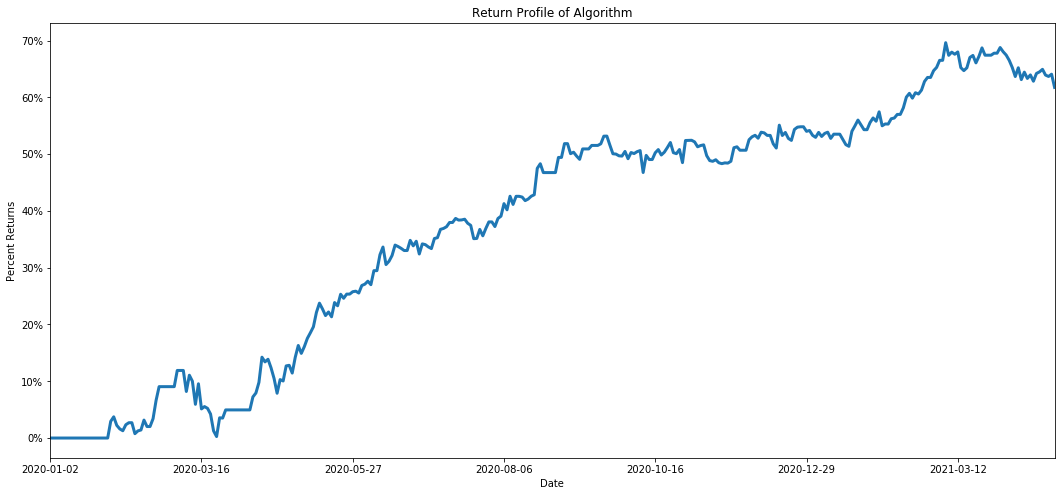

In [25]:
shares, cash, returns = backtest( orig_data, portfolioWeights, 1e6 )

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Return Profile of Algorithm")
plt.ylabel("Percent Returns")
returns.plot(ax=ax,linewidth=3)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

As we might have hoped, performance through market drops is strong. Returns are somewhat outsized due to our portfolio only being two stocks. For a finalized version of this algorithm, we might trade a hundred pairs or more to reduce volatility.

## 6. Conclusions & Potential Future Directions

Using the output of the 3 models (sparse inverse covariance estimation represented by Lasso Cross-Validation, clustering using Affinity Propagation, 2D embedding with Manifold learning) to identify stock pairs, we demonstrated a robust prototype for what would be built into a more sophisticated pairs trading algorithm. There are many places where this algorithm and approach could be improved, including expanding the portfolio, creating criteria for when $\beta$ is suitable to trade over, backtesting over more periods, using a Bayesian model with fewer simplifying assumptions, and investigating potential nonlinear relationships between stocks.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by AlphaWave Data, Inc. ("AlphaWave Data"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, AlphaWave Data, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to AlphaWave Data, Inc. at the time of publication. AlphaWave Data makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*